In [1]:
### Importing Modules and libraries

import numpy as np #Linear algebra
import pandas as pd #Data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # interactive visualizations
from skimage import io, color, morphology, filters, feature, segmentation, transform
import cv2 #process images to identify objects.
from os import listdir #  To get the list of all files and directories in the specified directory
from os.path import isfile, join # Check whether the specified path is an existing regular file or not.
import glob #  Identify the files

print('Set up complete')


Set up complete


In [2]:
### Create the datasets for each product and handle the images and labels for feature extraction, selection, statistical analysis and model evaluation
### Pre-Defined Functions

def create_dataset(paths:list, labels:list):

    """
    This function creates a dataset with a given list of directories; it will include the label indicated by a list of labels.
    """
    count=0

    labels = labels

    dataset = pd.DataFrame()

    for path in paths:

        onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]

        n_objects = len(onlyfiles)

        images = np.empty(n_objects, dtype=object)

        for i in range(n_objects):
            images[i] = io.imread(path + '/' + onlyfiles[i])

        images = pd.DataFrame(images, columns= ['image_array'])

        images['label'] = labels[count]

        dataset = pd.concat([dataset, images], axis = 0)

        count += 1

    return dataset

### This function will show an image per class given a dataframe.

def plot_one_per_class(source, target_name, class_col):
    from numpy import random

    uniques = np.unique(source[class_col])

    images = np.empty(len(uniques), dtype='object')

    count = 0
    for unique in uniques:

        subdf = source[source[class_col] == unique]

        i = random.randint(0,subdf.shape[0])

        images[count] = subdf.iloc[i,0]

        count += 1

    fig, ax = plt.subplots(1, len(uniques), figsize = (13,16))

    for j in range(len(uniques)):
        ax[j].imshow(images[j])
        ax[j].set_title(uniques[j] + ' leaf')

### Functions for feature ranking
### A quantity that measures a relationship between two random variables that are sampled simultaneously.

def mi_ranking(X, y, discrete_features = None):
    from sklearn.feature_selection import mutual_info_classif
    from sklearn.preprocessing import OrdinalEncoder

    features = X.columns.tolist()

    encoder = OrdinalEncoder()

    X = np.array(X)
    X = encoder.fit_transform(X)
    y = np.array(y)

    ranking = mutual_info_classif(X, y)

    features = pd.Index(features)
    ranking = pd.DataFrame(data = ranking)
    ranking = ranking.set_index(features)
    ranking = ranking.sort_values(by=[0], ascending = False)
    return ranking
### To compare the “multiple means” values of the data set

def ANOVA(data, feature, target):
    from scipy.stats import f_oneway

    uniques = list(np.unique(data[target]))

    analysis = pd.DataFrame()

    for i in range(len(uniques)):
        sample=data[feature][data[target] == uniques[i]]
        analysis = pd.concat([analysis, sample], axis = 1)

    col_names = ['sample' + str(i + 1) for i in range(len(uniques))]
    analysis.columns = col_names

    analysis = [analysis[col].dropna() for col in analysis]
    f_val, p_val = f_oneway(*analysis)

    return f_val, p_val
### To compare the means of two groups

def ttest(data, feature, target,val1, val2):
    from scipy.stats import ttest_ind

    sample1 = list(data[feature][data[target] == val1].values)

    sample2 = list(data[feature][data[target] == val2].values)

    tval, pval = ttest_ind(sample1, sample2)

    return tval, pval

### To show distributions of numeric data values, especially when you want to compare them between multiple groups.

def boxplots(data, var_of_interest: str, target: str,x_label: str, y_labels: str, titles: str):

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    count = 0

    uniques = list(np.unique(data[target]))

    for i in range(2):
        for j in range(2):

            data2 = []

            for unique in uniques:
                data2.append(list(data[var_of_interest[count]][data[target] == unique]))

            ax[i,j].boxplot(data2)
            ax[i,j].set_xticks(np.arange(1, len(uniques) + 1), labels=uniques)
            ax[i,j].set_xlabel(x_label)
            ax[i,j].set_ylabel(y_labels[count])
            ax[i,j].set_title(titles[count])

            count += 1

    plt.tight_layout()
    plt.show()

def variance_in_components(X,ncomponents):
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA

    ncomp = []
    var = []

    for i in range(1, ncomponents):
        scaler = StandardScaler()

        x = scaler.fit_transform(X)

        model = PCA(n_components = i)

        model.fit(x)

        var.append(model.explained_variance_ratio_.sum())

        ncomp.append(i)

    plt.figure(figsize = (5,5))
    plt.plot(ncomp, var)
    plt.ylabel("Variance explained")
    plt.xlabel("Number of components")
    plt.show()

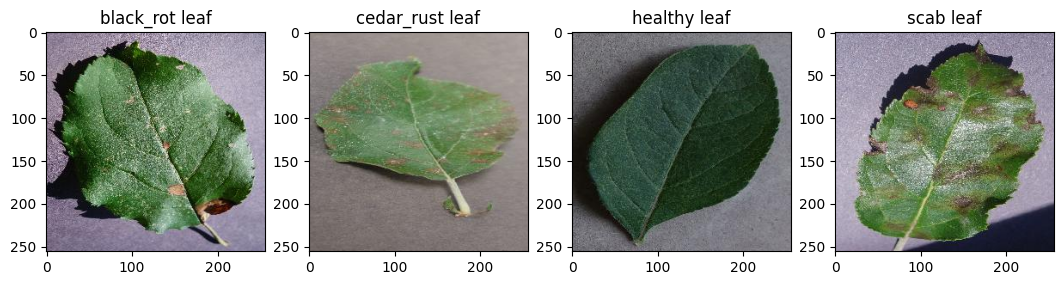

In [3]:
scab_path='/content/drive/MyDrive/Mini Project/plantvillage dataset/color/Apple___Apple_scab'
black_path='/content/drive/MyDrive/Mini Project/plantvillage dataset/color/Apple___Black_rot'
rust_path='/content/drive/MyDrive/Mini Project/plantvillage dataset/color/Apple___Cedar_apple_rust/'
healthy_path = '/content/drive/MyDrive/Mini Project/plantvillage dataset/color/Apple___healthy'

paths = [scab_path, black_path, rust_path, healthy_path]

labels = ['scab', 'black_rot', 'cedar_rust', 'healthy']

apples = create_dataset(paths, labels)

# apples.shape # check the size of the dataframe
# apples.isnull().sum() # run to check out if there is any null value

plot_one_per_class(apples, 'image_array', 'label')

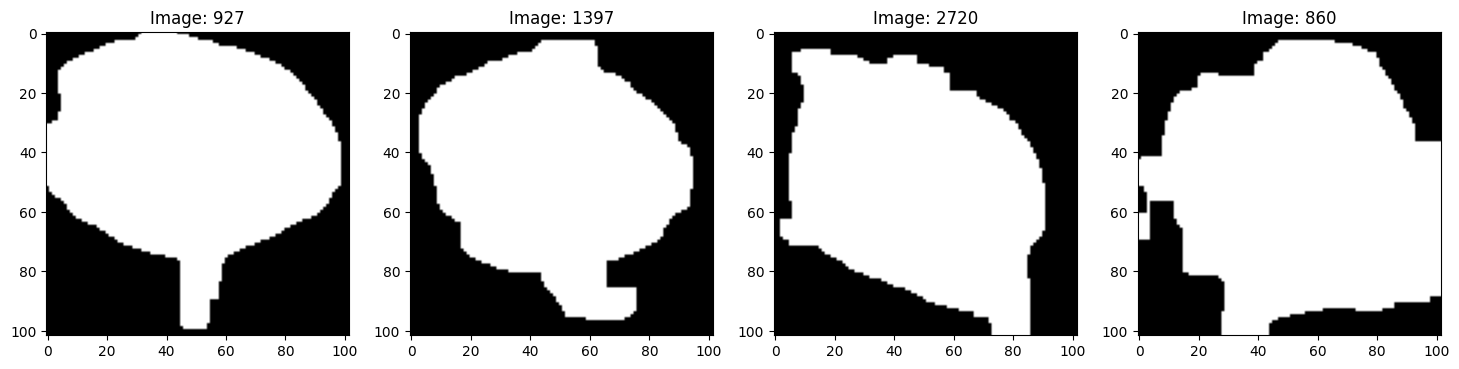

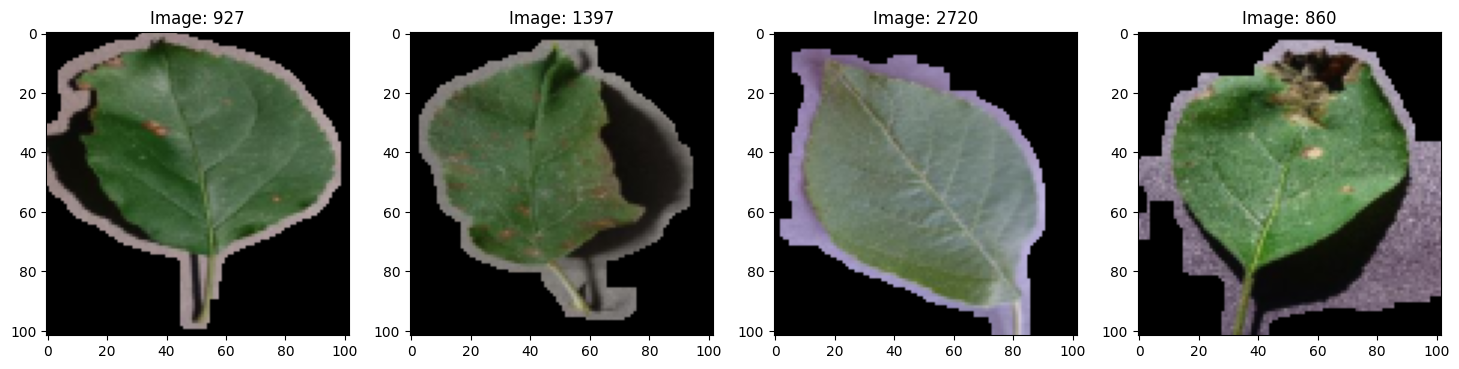

In [4]:
def overlay(img, mask, inverted = False):

    mask = np.dstack([(mask > 0)]*3) # create a mask with shape (X,Y,3)

    if inverted == False:
        result = img*(mask>0) # copy img into mask 1 values
    elif inverted:
        result = img*(mask==0) # copy img into mask 0 values

    return result

### Produces smoother, thinner, and cleaner images.

def canny_seg(img, kernel_size,sigma1, sigma2, low_t, high_t, mode = 'nearest'):
    from scipy import ndimage as ndi
    from skimage.feature import canny
    from skimage.morphology import square

    img = filters.gaussian(img, sigma1, channel_axis = -1) # smoothing

    img = color.rgb2gray(img) # convert to grayscale

    edges = canny(img, sigma2, low_threshold = low_t, high_threshold = high_t, mode =mode) # edge detection

    filled = morphology.dilation(edges, square(kernel_size)) # dilation

    filled = ndi.binary_fill_holes(filled) # fill holes within edges

    filled = morphology.closing(filled, square(kernel_size)) # clean mask

    filled = ndi.binary_fill_holes(filled) # fill holes again

    return filled

from numpy import random

numbers = [random.randint(0, apples.shape[0]) for i in range(4)]

fig, ax = plt.subplots(1,4, figsize = (18,8))

for i in range(4):
    img = apples.iloc[numbers[i], 0]
    img = transform.rescale(img, 0.40, channel_axis = -1)
    mask = canny_seg(img, 6, 0.8, 0.5,0.07,0.250)
    ax[i].imshow(mask, cmap='gray')
    ax[i].set_title(f"Image: {numbers[i]}")

plt.show()

fig, ax = plt.subplots(1,4, figsize = (18,8))
for i in range(4):
    img = apples.iloc[numbers[i], 0]
    img = transform.rescale(img, 0.40, channel_axis = -1)
    mask = canny_seg(img, 6, 0.8, 0.5,0.07,0.250) # edge detection
    img_ov = overlay(img, mask)
    ax[i].imshow(img_ov)
    ax[i].set_title(f"Image: {numbers[i]}")

plt.show()

In [5]:
#### Statistical color features

def get_color_features(img):
    results = np.zeros(shape=(12,))
    count = 0
    for j in range(img.shape[2]):

        results[count]= img.T[j].flatten()[np.nonzero(img.T[j].flatten())].mean()

        count += 1

        results[count]= img.T[j].flatten()[np.nonzero(img.T[j].flatten())].std()

        count += 1

        results[count]= img.T[j].flatten()[np.nonzero(img.T[j].flatten())].min()

        count += 1

        results[count]= img.T[j].flatten()[np.nonzero(img.T[j].flatten())].max()

        count += 1

    return results

def feature_extraction(data, labels_loc, target_loc, convert = 'rgb',save_labels=False):

    labels = data[labels_loc]

    nsamples = len(labels)

    results = np.empty(shape=(nsamples, 12))

    for i in range(nsamples):
        img = data.iloc[i,0]

        if convert == 'lab':
            img = color.rgb2lab(img)
        elif convert == 'hsv':
            img = color.rgb2hsv(img)

        img = transform.rescale(img, 0.40, channel_axis = -1) #rescale to 40 %

        mask = canny_seg(img, 6, 0.8, 0.5,0.07,0.250) # segmentation

        work_img = overlay(img, mask) # overlay img

        results[i,:] = get_color_features(work_img) # calculate and append results into array

        if i % 500 == 0:
            print(f"======> {i} images processed....")

    cols = ['mean_c1_'+ convert,'std_c1_'+convert, 'min_c1_'+convert, 'max_c1_'+convert,
           'mean_c2_'+convert,'std_c2_'+convert, 'min_c2_'+convert, 'max_c2_'+convert,
           'mean_c3_'+convert,'std_c3_'+convert, 'min_c3_'+convert, 'max_c3_'+convert]

    df = pd.DataFrame(data = results, columns = cols)

    if save_labels == True:
        df['true_label'] = data[labels_loc].values

    return df

In [6]:
import time
start = time.time()

rgb = feature_extraction(apples, 'label', 'image_array')
lab = feature_extraction(apples, 'label', 'image_array', convert = 'lab', save_labels = True)

end = time.time()

print(f"Feature extraction took {(end-start)/60} minutes")

data = pd.concat([rgb,lab], axis = 1) # concatenate all results by cols

data.head()

del rgb, lab # delete original dataframes to release memory

======> 0 images processed....
======> 500 images processed....
======> 1000 images processed....
======> 1500 images processed....
======> 2000 images processed....
======> 2500 images processed....
======> 3000 images processed....
======> 0 images processed....
======> 500 images processed....
======> 1000 images processed....
======> 1500 images processed....
======> 2000 images processed....
======> 2500 images processed....
======> 3000 images processed....
Feature extraction took 3.0698440790176393 minutes


In [7]:
### make ANOVA for each column in the data extracted
for col in data.columns.tolist()[:-1]:
    f_val, p_val = ANOVA(data, col,'true_label')
    print(f"The ANOVA demonstrated {'significant' if p_val < 0.05 else 'not significat'} difference (pval = {p_val}) for {col} feature")

The ANOVA demonstrated significant difference (pval = 3.1097607809998646e-86) for mean_c1_rgb feature
The ANOVA demonstrated significant difference (pval = 2.5836965179811517e-159) for std_c1_rgb feature
The ANOVA demonstrated significant difference (pval = 3.1068536604237115e-157) for min_c1_rgb feature
The ANOVA demonstrated significant difference (pval = 3.2070072606865547e-108) for max_c1_rgb feature
The ANOVA demonstrated significant difference (pval = 2.3941245765057687e-119) for mean_c2_rgb feature
The ANOVA demonstrated significant difference (pval = 1.988884708672475e-49) for std_c2_rgb feature
The ANOVA demonstrated significant difference (pval = 4.874758068873037e-144) for min_c2_rgb feature
The ANOVA demonstrated significant difference (pval = 2.8461082251071295e-49) for max_c2_rgb feature
The ANOVA demonstrated significant difference (pval = 1.674304250323063e-17) for mean_c3_rgb feature
The ANOVA demonstrated significant difference (pval = 6.737054788544184e-116) for std_

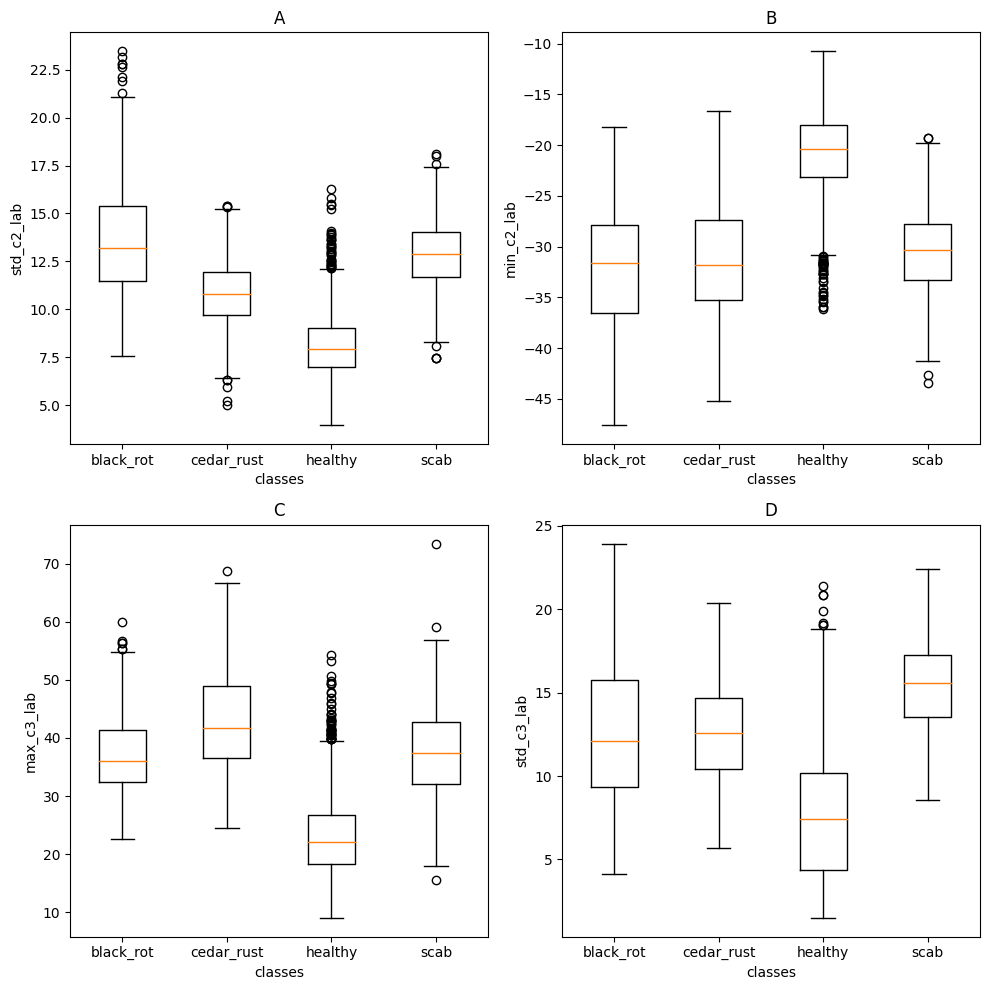

In [8]:
### ranking features and make boxplots for visualization the 4 most important features
mi_rank = mi_ranking(X=data.iloc[:,:-1], y = data['true_label'])

features= mi_rank.iloc[:4,0].index.values.tolist()
titles = ['A','B','C', 'D']

boxplots(data, var_of_interest=features, target='true_label',x_label='classes', y_labels= features, titles=titles)

In [9]:
## apply ttest for healthy vs cedar rust in the 'max_c2_lab' most important features
tval, p_val = ttest(data, 'max_c2_lab', 'true_label','healthy', 'cedar_rust')

print(f"The test demonstrated {'significant' if p_val < 0.05 else 'not significat'} difference (pval = {p_val}) between classes")

The test demonstrated not significat difference (pval = 0.4249440937820127) between classes


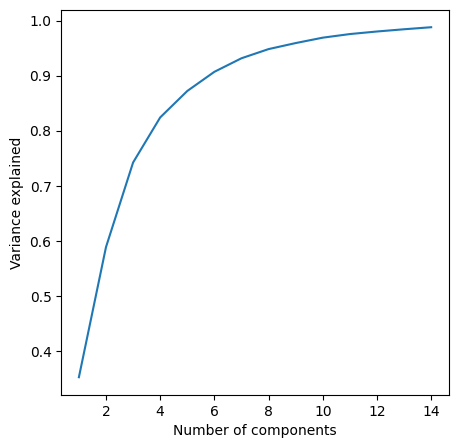

In [10]:
## PCA for feature selection
X = np.array(data.drop(['true_label'], axis = 1))

variance_in_components(X, 15) # pca is loaded within the function

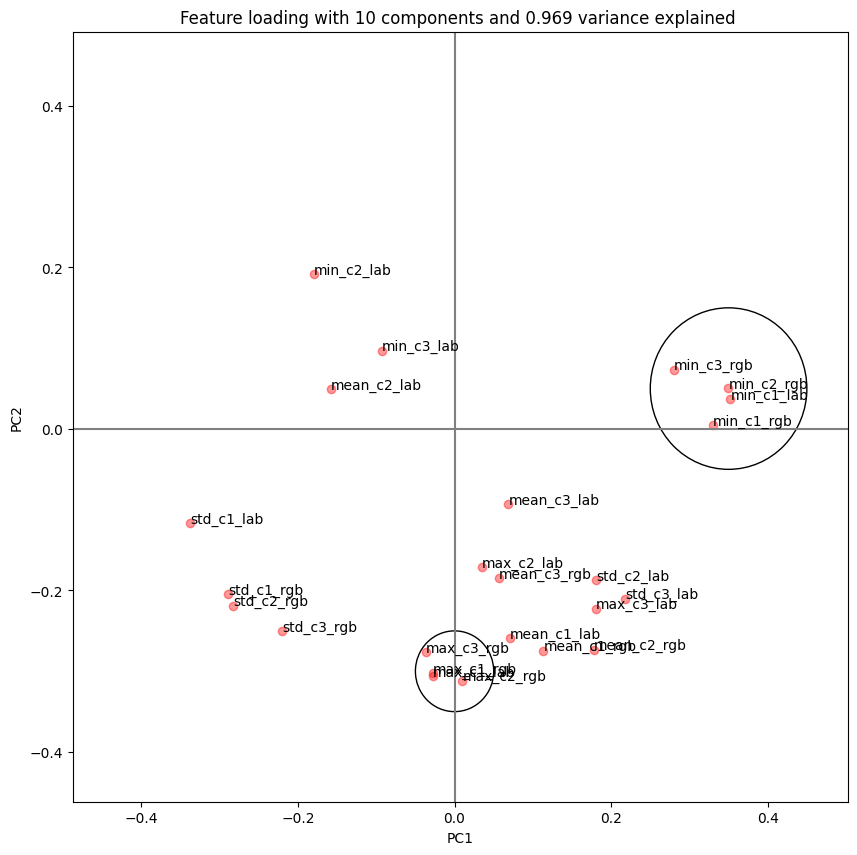

In [11]:
# PCA for feature visualization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sc = StandardScaler()

X = data.drop(['true_label'],axis =1)
X = sc.fit_transform(X)

mypca = PCA(10) # 10 components which explains >90 % of variance

mypca.fit(X)

pca_feat_importance = pd.DataFrame(mypca.components_,columns=sc.feature_names_in_) # extract loading of features for each component

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(pca_feat_importance.iloc[1,:], pca_feat_importance.iloc[0,:], color = 'red', alpha = 0.4)

for i in range(len(pca_feat_importance.columns.tolist())):
    x = pca_feat_importance.iloc[1,i]
    y = pca_feat_importance.iloc[0,i]
    name = pca_feat_importance.columns.tolist()[i]
    plt.text(x, y, name)

ax.set_xlim(min(pca_feat_importance.iloc[1,:]) - 0.15, max(pca_feat_importance.iloc[1,:]) + 0.15)
ax.set_ylim(min(pca_feat_importance.iloc[0,:]) - 0.15, max(pca_feat_importance.iloc[0,:]) + 0.30)

plt.axvline(x=0, c="gray")
plt.axhline(y=0, c="gray")

circle1 = plt.Circle((0.35, 0.05),0.1 ,fill = False )
circle2 = plt.Circle((0, -0.3),0.05 ,fill = False )

ax.add_artist(circle1)
ax.add_artist(circle2)

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title(f"Feature loading with 10 components and {round(mypca.explained_variance_ratio_.sum(),3)} variance explained ")

plt.show()

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
scaler = StandardScaler()

X = data.drop(['true_label'],axis =1)
y = data['true_label']

X = scaler.fit_transform(X)

selector = PCA(10) # 10 components which explains >90 % of variance

X = selector.fit_transform(X)

clf = LogisticRegression()

y_pred =  cross_val_predict(clf, X, y, cv = 10)

metrics = classification_report(y, y_pred, output_dict = True)

metrics = pd.DataFrame(metrics)

metrics.head()

,black_rot,cedar_rust,healthy,scab,accuracy,macro avg,weighted avg
precision,0.946203,0.921429,0.959295,0.908646,0.943551,0.933893,0.943385
recall,0.962963,0.938182,0.959878,0.884127,0.943551,0.936288,0.943551
f1-score,0.954509,0.929730,0.959587,0.896219,0.943551,0.935011,0.943413
support,621.000000,275.000000,1645.000000,630.000000,0.943551,3171.000000,3171.000000
